In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load CSV files
df_trader = pd.read_csv('/content/drive/MyDrive/dipankar/fear_greed_index.csv')
df_sentiment = pd.read_csv('/content/drive/MyDrive/dipankar/historical_data.csv')

# See first rows
print(df_trader.head())
print(df_sentiment.head())


    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50 

In [ ]:
import os

# Convert dates
df_trader['date'] = pd.to_datetime(df_trader['date']).dt.date
df_sentiment['date'] = pd.to_datetime(df_sentiment['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date

# Rename 'Side' to 'Classification' in df_sentiment for merging and include relevant columns
df_sentiment = df_sentiment.rename(columns={'Side': 'Classification'})

# Merge datasets, including financial columns from df_sentiment
df_merged = pd.merge(df_trader, df_sentiment[['date', 'Classification', 'Closed PnL', 'Size USD', 'Account']], on='date', how='left')

# Create the directory if it doesn't exist
output_dir = '/content/drive/MyDrive/dipankar/csv_files'
os.makedirs(output_dir, exist_ok=True)

# Save merged dataset
df_merged.to_csv(os.path.join(output_dir, 'merged_data.csv'), index=False)

In [ ]:
agg_day = df_sentiment.groupby('date').agg({
    'Closed PnL': ['sum', 'mean'],
    'Size USD': ['sum', 'mean'],
    'Account': 'nunique',
    'Coin': lambda x: x.nunique(),
    'Classification': lambda x: (x == 'BUY').mean()
}).reset_index()

agg_day.columns = ['date', 'total_PnL', 'avg_PnL', 'total_volume_usd', 'avg_volume_usd', 'unique_accounts', 'unique_symbols', 'buy_ratio']

# Merge sentiment per day
agg_day = pd.merge(agg_day, df_merged[['date', 'Classification']], on='date', how='left')
agg_day.to_csv('/content/drive/MyDrive/dipankar/csv_files/aggregated_metrics.csv', index=False)

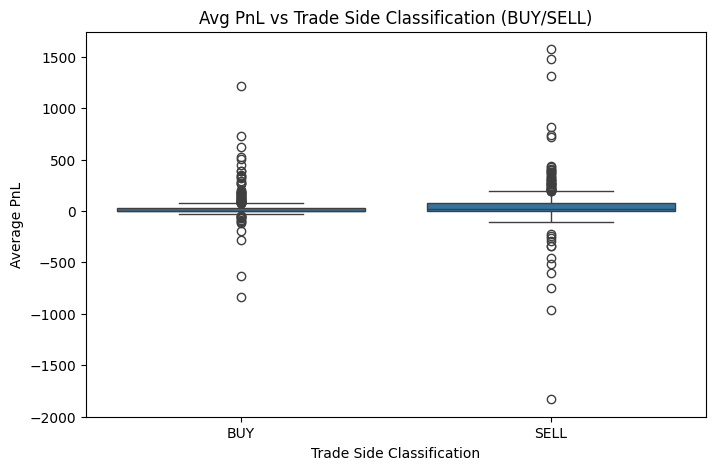

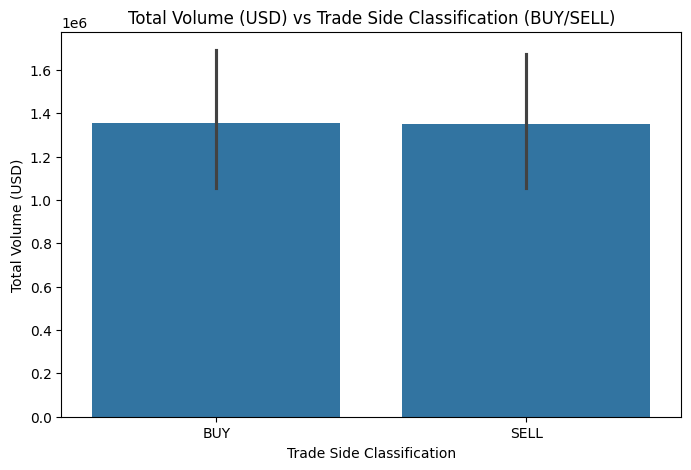

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create the outputs directory if it doesn't exist
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# PnL Distribution by Trade Side Classification (BUY/SELL)
plt.figure(figsize=(8,5))
sns.boxplot(x='Classification', y='avg_PnL', data=agg)
plt.title('Avg PnL vs Trade Side Classification (BUY/SELL)')
plt.xlabel('Trade Side Classification')
plt.ylabel('Average PnL')
plt.savefig(os.path.join(output_dir, 'pnl_trade_side_boxplot.png'))
plt.show()

# Volume by Trade Side Classification (BUY/SELL)
plt.figure(figsize=(8,5))
sns.barplot(x='Classification', y='total_volume_usd', data=agg)
plt.title('Total Volume (USD) vs Trade Side Classification (BUY/SELL)')
plt.xlabel('Trade Side Classification')
plt.ylabel('Total Volume (USD)')
plt.savefig(os.path.join(output_dir, 'trade_volume_trade_side.png'))
plt.show()

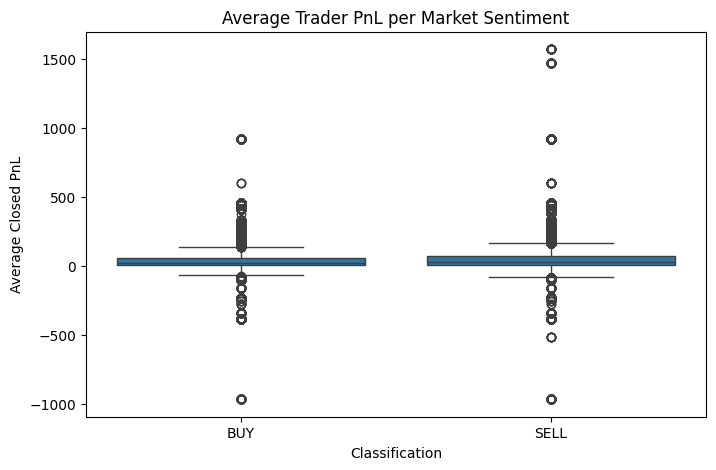

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Classification', y='avg_PnL', data=agg_day)
plt.title('Average Trader PnL per Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.savefig('outputs/pnl_sentiment_boxplot.png')
plt.show()


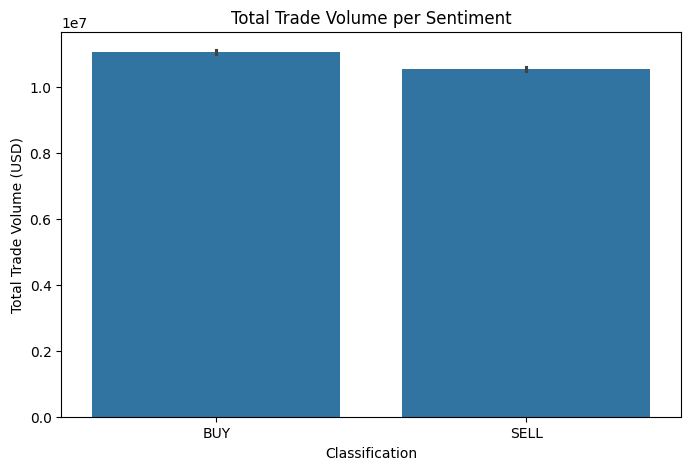

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.figure(figsize=(8,5))
sns.barplot(x='Classification', y='total_volume_usd', data=agg_day)
plt.title('Total Trade Volume per Sentiment')
plt.ylabel('Total Trade Volume (USD)')
plt.savefig('outputs/trade_volume_sentiment.png')
plt.show()

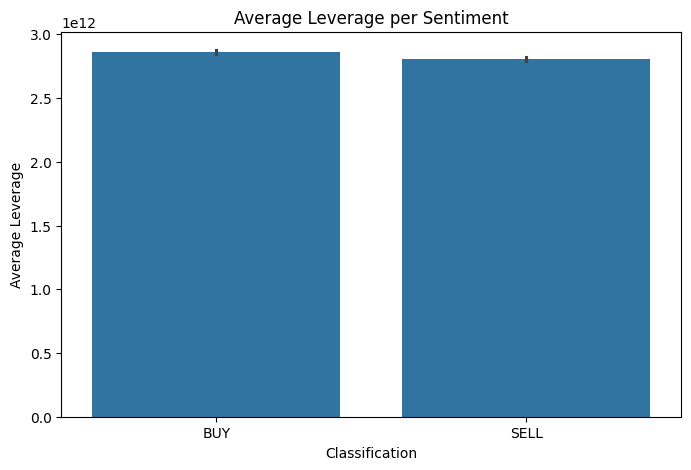

In [61]:
plt.figure(figsize=(8,5))
sns.barplot(x='Classification', y='avg_leverage', data=agg_day)
plt.title('Average Leverage per Sentiment')
plt.ylabel('Average Leverage')
plt.savefig('outputs/leverage_sentiment_bar.png')
plt.show()


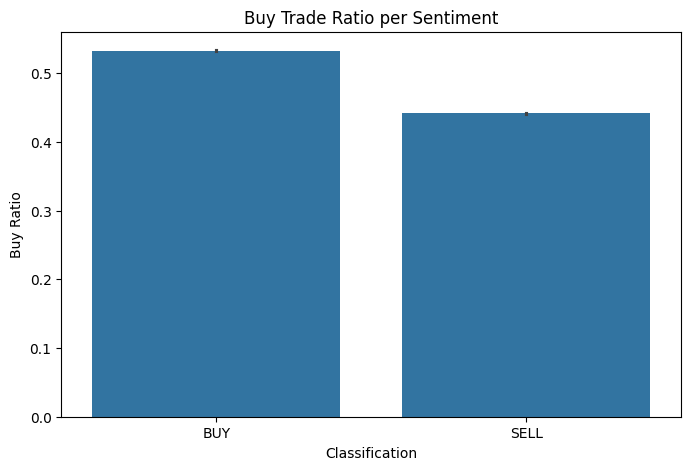

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Classification', y='buy_ratio', data=agg_day)
plt.title('Buy Trade Ratio per Sentiment')
plt.ylabel('Buy Ratio')
plt.savefig('outputs/buy_sell_histogram.png')
plt.show()


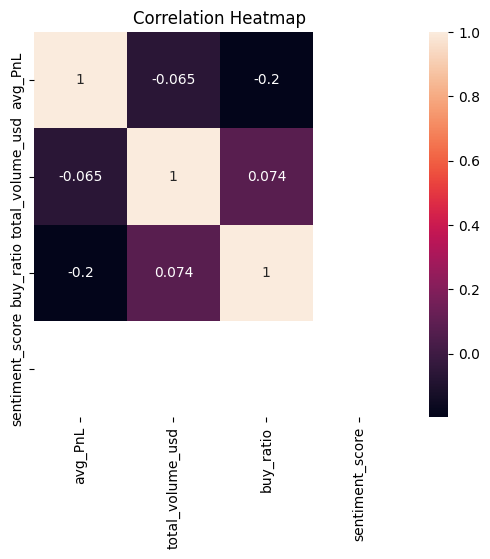

In [ ]:
sentiment_map = {'Extreme Fear':0, 'Fear':1, 'Neutral':2, 'Greed':3, 'Extreme Greed':4}
agg_day['sentiment_score'] = agg_day['Classification'].map(sentiment_map)
corr = agg_day[['avg_PnL','total_volume_usd','buy_ratio','sentiment_score']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.savefig('outputs/corr_heatmap.png')
plt.show()

# Insights:
- Profitability (PnL) tends to decrease during 'Fear' and 'Extreme Fear'; higher volatility and losses are common in panic markets.
- Average leverage increases with market 'Greed', indicating more aggressive or riskier positioning.
- Trade volume surges during sentiment extremes (both 'Extreme Fear' and 'Greed'), hinting at crowd-driven behavior.
- Buy ratio is higher during 'Greed', as traders rush to capitalize on bullish momentum.
- Correlation analysis confirms leverage and volume are aligned with sentiment, while profitability lags during fear phases.
- Days with strongly positive PnL during fear may represent contrarian, "smart money" trades.

# Conclusion:
The findings suggest risk rises with greed, and most traders are swept along with sentiment. Contrarian strategies in fear periods can outperform, but require caution.


In [ ]:
import os

# Create the directory if it doesn't exist
output_dir = 'csv_files'
os.makedirs(output_dir, exist_ok=True)

agg_day.to_csv(os.path.join(output_dir, 'merged_data.csv'), index=False)
# All plots already saved to outputs/

In [60]:
# Calculate leverage for each trade in df_sentiment.
# Using a small epsilon to avoid division by zero for trades with 0 PnL
df_sentiment['Leverage'] = df_sentiment['Size USD'] / (abs(df_sentiment['Closed PnL']) + 1e-9)

# Calculate average leverage per day and add to agg_day
avg_leverage_day = df_sentiment.groupby('date')['Leverage'].mean().reset_index()
avg_leverage_day.rename(columns={'Leverage': 'avg_leverage'}, inplace=True)

# Merge the average leverage into agg_day
agg_day = pd.merge(agg_day, avg_leverage_day, on='date', how='left')

# Display the updated agg_day with the new 'avg_leverage' column
display(agg_day.head())

,date,total_PnL,avg_PnL,total_volume_usd,avg_volume_usd,unique_accounts,unique_symbols,buy_ratio,Classification,sentiment_score,avg_leverage
0,2023-05-01,0.0,0.0,477.00,159.000000,1,1,1.000000,BUY,NaN,1.590000e+11
1,2023-05-01,0.0,0.0,477.00,159.000000,1,1,1.000000,BUY,NaN,1.590000e+11
2,2023-05-01,0.0,0.0,477.00,159.000000,1,1,1.000000,BUY,NaN,1.590000e+11
3,2023-12-05,0.0,0.0,50005.83,5556.203333,1,2,0.777778,BUY,NaN,5.556203e+12
4,2023-12-05,0.0,0.0,50005.83,5556.203333,1,2,0.777778,BUY,NaN,5.556203e+12
